# Parameter Distributions

This notebook plots the parameter distributions as color gradients and variances of matrices.
It also produces clustered PCAs of multimodal distributions.
It produces figs. 3A and 4A and supplementary figs. S3-S6.

In [3]:
import numpy as np
from utils import plotting

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

burn_in = 0.2

We will first look at the parameter distribution of the symsparse models:

In [ ]:
data_name = "G13_COAD_12"

samples = np.load(
    "../results/mcmc/G13_LUAD_12_symsparse_MALA_0_0015185546875000002.npy"
    if data_name == "G13_LUAD_12"
    else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy"
    if data_name == "G13_COAD_12"
    else None
)
samples = samples[:, int(burn_in * samples.shape[1]):]
samples = samples.reshape(-1, samples.shape[2])

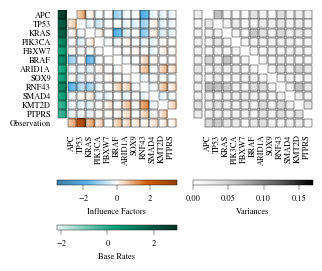

In [ ]:
tile_len = 10

quantiles = np.quantile(samples,
                        np.linspace(0.05, 0.95, tile_len),
                        axis=0).T.reshape(13, -1)
variances = np.var(samples, axis=0).reshape(13, -1)

fig = plt.figure(figsize=(3.21, 2.8))
gs = mpl.gridspec.GridSpec(
    3, 2, height_ratios=[1., 0.035, 0.035])

border_len = 0.1
br_ir_sep = 0.2

ax = np.array([
    fig.add_subplot(gs[0, i]) for i in range(2)])
cbar_ax = np.array([fig.add_subplot(gs[1 + i // 2, i % 2])
                   for i in range(3)])

br_min = -2.2
br_max = 3
max_abs_ir = 3.6
max_var = 0.17

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)
n_events = data.shape[1]
event_names = data.columns.tolist()

plotting.plot_theta_dist(
    quantiles=quantiles,
    tile_len=tile_len,
    n_events=n_events,
    abs_max_ir=max_abs_ir,
    min_br=br_min,
    max_br=br_max,
    events=event_names,
    ax=ax[0])
plotting.plot_theta_var(
    variances=variances,
    n_events=n_events,
    max_var=max_var,
    events=event_names,
    ax=ax[1])

ax[0].set_yticks(np.arange(0.5, n_events + 1 +
                           n_events * border_len, 1 + border_len))
ax[0].set_yticklabels(
    event_names + ["Observation"], )
ax[0].tick_params(length=0, pad=4)

for j in range(2):
    ax[j].set_xticks(
        [0.5]
        + (np.arange(1.5, n_events + 1 + n_events *
                     border_len,
                     1 + border_len) + br_ir_sep).tolist())
    ax[j].set_xticklabels([""] + event_names, rotation=90)
    ax[j].tick_params(length=0, pad=4)

cbars = list()
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=-max_abs_ir, vmax=max_abs_ir), cmap=plotting.OI_RdBu),
    cax=cbar_ax[0],
    label="Influence Factors",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=0, vmax=max_var), cmap="Greys"),
    cax=cbar_ax[1],
    label="Variances",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=br_min, vmax=br_max), cmap=plotting.OI_Greens),
    cax=cbar_ax[2],
    label="Base Rates",
    orientation="horizontal",
))

for cbar in cbars:
    cbar.outline.set_linewidth(0.3)
    cbar.ax.tick_params(width=0.3)

fig.tight_layout()
fig.savefig(f"../results/figs/{data_name}_param_dist.pdf")

## Parameter Distribution of the L1 Models

Now, let us load the L1 samples

In [1]:
import umap
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA

2026-02-09 08:03:21.949490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 08:03:22.085155: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 08:03:22.089648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-09 08:03:22.089689: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [ ]:
data_name = "G13_COAD_12"

samples = np.load(
    "../results/mcmc/G13_LUAD_12_l1_MALA_0_001.npy"
    if data_name == "G13_LUAD_12"
    else "../results/mcmc/G13_COAD_12_l1_MALA_0_0015625.npy")[:, ::10]
samples = samples[:, int(burn_in * samples.shape[1]):]
samples = samples.reshape(-1, samples.shape[2])

In [ ]:
n_components = 2
clusterable_embedding = umap.UMAP(n_components=n_components, random_state=0)\
    .fit_transform(samples)
labels = HDBSCAN(
    min_samples=100,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)
standard_embedding = PCA(n_components=n_components).fit_transform(samples)
clustered = (labels >= 0)

/home/lhu/mhn_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


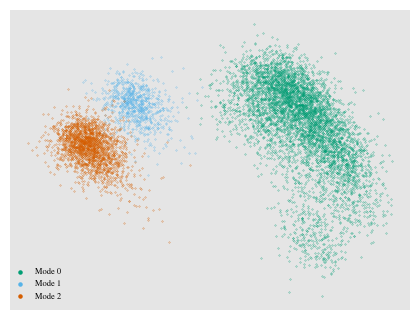

In [ ]:
if n_components == 3:
    fig = plt.figure(figsize=(1.5, 1.5))
    ax = fig.add_subplot(projection='3d')
else:
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
for label in np.unique(labels):
    if label == -1:
        continue
    ax.scatter(
        *standard_embedding[labels == label].T,
        s=0.05,
        label=f"Mode {label}",
        rasterized=True
    )
if n_components == 3:
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])

fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.set_facecolor("#E5E5E5")
for spine in ax.spines.values():
    spine.set_visible(False)

fig.savefig(
    f"../results/figs/{data_name}_l1_pca.pdf", dpi=600
)

fig.set_size_inches(4, 3)
legend = fig.legend(loc=(0.02, 0.05), markerscale=10)
legend.set_frame_on(False)
fig.savefig(
    f"../results/figs/{data_name}_l1_pca_supp.pdf", dpi=600
)

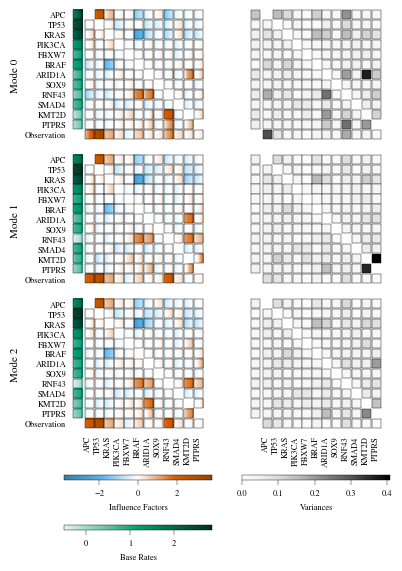

In [ ]:
tile_len = 10

quantiles = [np.quantile(samples[labels == label],
                         np.linspace(0.05, 0.95, tile_len),
                         axis=0).T.reshape(13, -1)
             for label in np.unique(labels) if label != -1]
variances = [np.var(samples[labels == label], axis=0).reshape(
    13, -1) for label in np.unique(labels) if label != -1]

n_rows = 3
fig = plt.figure(figsize=(3.95, 5.7))
gs = mpl.gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1., 0.13])
theta_gs = mpl.gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=gs[0], hspace=0.1)
cbar_gs = mpl.gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=gs[1], hspace=10)


border_len = 0.1
br_ir_sep = 0.2

ax = np.array([[
    fig.add_subplot(theta_gs[j, i])
    for i in range(2)] for j in range(3)])
cbar_ax = np.array([fig.add_subplot(cbar_gs[i // 2, i % 2])
                   for i in range(3)])

br_min = min(plotting.min_max_br(q, tile_len)[0]
             for q in quantiles)
br_max = max(plotting.min_max_br(q, tile_len)[1]
             for q in quantiles)
max_abs_ir = max(plotting.max_abs_ir(q, tile_len)
                 for q in quantiles)
max_var = max(v.max() for v in variances)

for i, (mode_name, _quantiles, _variances) in enumerate(
    zip(["Mode 0", "Mode 1", "Mode 2"],
        quantiles,
        variances)
):

    data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)
    n_events = data.shape[1]
    event_names = data.columns.tolist()

    ax[i, 0].set_ylabel(mode_name, fontsize=8)
    plotting.plot_theta_dist(
        quantiles=_quantiles,
        tile_len=tile_len,
        n_events=n_events,
        abs_max_ir=max_abs_ir,
        min_br=br_min,
        max_br=br_max,
        events=event_names,
        ax=ax[i, 0])
    plotting.plot_theta_var(
        variances=_variances,
        n_events=n_events,
        max_var=max_var,
        events=event_names,
        ax=ax[i, 1])

    ax[i, 0].set_yticks(np.arange(0.5, n_events + 1 +
                                  n_events * border_len, 1 + border_len))
    ax[i, 0].set_yticklabels(
        event_names + ["Observation"], )
    ax[i, 0].tick_params(length=0, pad=4)
    ax[i, 1].tick_params(length=0, pad=4)

for j in range(2):
    ax[-1, j].set_xticks(
        [0.5]
        + (np.arange(1.5, n_events + 1 + n_events *
                     border_len,
                     1 + border_len) + br_ir_sep).tolist())
    ax[-1, j].set_xticklabels([""] + event_names, rotation=90)
    ax[-1, j].tick_params(length=0, pad=4)

cbars = list()
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=-max_abs_ir, vmax=max_abs_ir), cmap=plotting.OI_RdBu),
    cax=cbar_ax[0],
    label="Influence Factors",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=0, vmax=max_var), cmap="Greys"),
    cax=cbar_ax[1],
    label="Variances",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=br_min, vmax=br_max), cmap=plotting.OI_Greens),
    cax=cbar_ax[2],
    label="Base Rates",
    orientation="horizontal",
))

for cbar in cbars:
    cbar.outline.set_linewidth(0.3)
    cbar.ax.tick_params(width=0.3)

fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_l1_param_dist_modes.pdf"
)

In [ ]:
means = [np.mean(samples[labels == label], axis=0)
         for label in np.unique(labels) if label != -1]

In [69]:
differential_params = np.ndarray(0)
for i in range(3):
    for j in range(i+1, 3):
        differential_params = np.concatenate([differential_params, np.where(
            np.abs(means[i] - means[j]) > 0.6)[0]])
differential_params = np.unique(differential_params).astype(int)

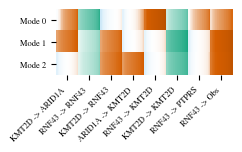

In [ ]:
fig, ax = plt.subplots(figsize=(len(differential_params) * 0.3, 2.1))

for m, index in enumerate(differential_params):
    index_i, index_j = (index // 12), (index % 12)
    for i in range(3):
        ax.imshow(
            quantiles[i][[index_i], index_j*tile_len:(index_j+1)*tile_len],
            aspect='equal',
            cmap=plotting.OI_Greens if index_i == index_j else plotting.OI_RdBu,
            vmin=br_min if index_i == index_j else -max_abs_ir,
            vmax=br_max if index_i == index_j else max_abs_ir,
            extent=(m-0.5, m + 0.5, i-0.5, i+0.5)
        )
ax.set_xticks(ticks=np.arange(len(differential_params)),
              labels=[f"{event_names[index % 12]} -> {(event_names + ['Obs'])[index // 12]}"
                      for index in differential_params], rotation=45, ha='right')
ax.set_yticks(ticks=np.arange(3), labels=[f"Mode {i}" for i in range(3)])
ax.set_xlim(-0.5, len(differential_params)-0.5)
ax.set_ylim(2.5, -0.5)

for spine in ax.spines.keys():
    ax.spines[spine].set_visible(False)
fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_l1_param_dist_differential.pdf",
)